In [1]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import numpy as np

from generation.data.data_preparation import get_attributes_df, \
                                             get_detector_event_df, \
                                             generate_one_signal, \
                                             postprocess_signal

In [2]:
df = get_attributes_df()
df = get_detector_event_df(df, detector=13)

In [4]:
PROCESSING_TIME_NORM_COEF = 50

def postprocess_signal(signal, ):
    """
    Getting result signal after photodetector
    :param signal: Output from generate_detector_event_output
    :return: processed signal
    """
    def build_kernel(x_cur, energy, x_min, x_max):
        kernel = lambda x: ((x - x_cur) ** 2) / np.exp((x - x_cur) / PROCESSING_TIME_NORM_COEF)
        x_linspace = np.linspace(x_min, x_max, x_max - x_min)
        y_linspace = energy * np.array(list(map(kernel, x_linspace)))
        y_linspace[:x_cur] = np.zeros(x_cur)
        return y_linspace

    result = np.zeros(len(signal))
    for x_cur, energy in enumerate(signal):
        y_cur = build_kernel(x_cur, energy, x_min=0, x_max=len(signal))
        result += y_cur
    return result

In [5]:
unique_events = df['event'].unique()
events_dfs = [df[df['event'] == int(event)] for event in tqdm.tqdm(unique_events)]

100%|██████████| 74/74 [00:16<00:00,  4.59it/s]


In [ ]:
events_signals = [generate_one_signal(event_df, steps_num=1024, sample_coef=1) for event_df in tqdm.tqdm(events_dfs)]

 51%|█████▏    | 38/74 [02:51<02:20,  3.91s/it]

In [ ]:
events_postprocessed_signals = [postprocess_signal(signal) for signal in events_signals]

In [ ]:
mins = np.min(events_postprocessed_signals, axis=1)
maxs = np.max(events_postprocessed_signals, axis=1)
half_amplitudes = mins + (maxs - mins) / 2

In [ ]:
def get_baseline_prediction(signal, half_amplitude):
    prev = signal[0]
    for idx, item in enumerate(signal):
        if item > half_amplitude:
            return idx

In [ ]:
for item in (events_postprocessed_signals / np.max(events_postprocessed_signals, axis=1)[:, None]):
    plt.plot(item)
plt.show()

In [9]:
preds = [get_baseline_prediction(events_postprocessed_signals[i], half_amplitudes[i]) for i in range(len(half_amplitudes))]

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 71.]),
 array([14. , 14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. ]),
 <a list of 10 Patch objects>)

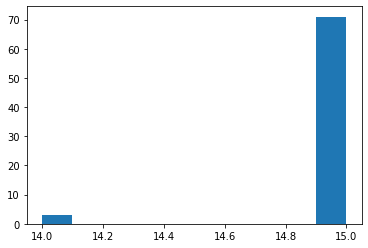

In [10]:
plt.hist(preds)